In [1]:
# Download kaggle.json dari Google Drive (publik)
!curl -L -o kaggle.json "https://drive.google.com/uc?export=download&id=1Le1-7h_kScysxZOTrTKjQx6keawnPErV"

# Setup kaggle CLI
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI dan download dataset
!pip install -q kaggle
!kaggle datasets download -d arjuntejaswi/plant-village
!unzip -q plant-village.zip -d plant_village

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100    70  100    70    0     0     16      0  0:00:04  0:00:04 --:--:--    46
Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 96% 315M/329M [00:04<00:00, 54.0MB/s]
100% 329M/329M [00:04<00:00, 76.9MB/s]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
# Path ke folder dataset
data_dir = "plant_village/PlantVillage"

# Split otomatis ke training dan validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Melatih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - accuracy: 0.3257 - loss: 2.0791 - val_accuracy: 0.6038 - val_loss: 1.2372
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 188ms/step - accuracy: 0.6731 - loss: 0.9526 - val_accuracy: 0.7528 - val_loss: 0.7492
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 185ms/step - accuracy: 0.7544 - loss: 0.7426 - val_accuracy: 0.7397 - val_loss: 0.7346
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 187ms/step - accuracy: 0.7916 - loss: 0.6158 - val_accuracy: 0.7948 - val_loss: 0.6016
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.8286 - loss: 0.5111 - val_accuracy: 0.8328 - val_loss: 0.4837
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 97s 188ms/step - accuracy: 0.8434 - loss: 0.4583 - val_accuracy: 0.8493 - val_loss: 0.4389
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8591 - loss: 0.4161 - val_accuracy: 0.8646 - val_loss: 0.3958
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 95s 184ms/step - accuracy: 0.8820 - loss: 

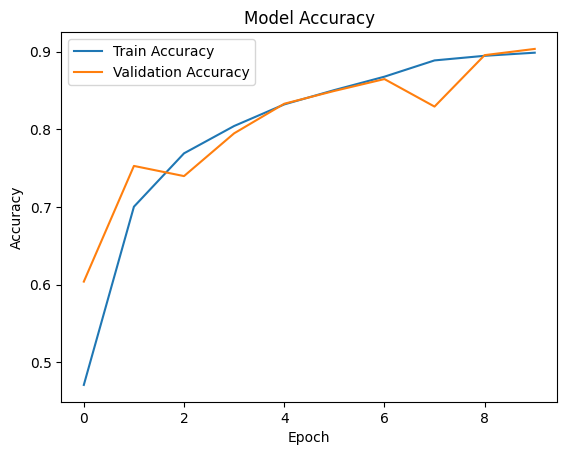

In [5]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.2
astropy-iers-data==0.2025.5.12.0.38.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.4.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.2
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.10.0
click==8.2.0
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet